<center>

# FraudHunter

### <i> Progetto per l'esame di Programmazione di applicazioni di Data Intensive (2025) </i>

### Alessandro Valmori
#### Matricola: 0001089308
#### alessandro.valmori2@studio.unibo.it
</center>

## 1. Introduzione e Obiettivo del Progetto

Questo progetto si concentra sull'analisi di un dataset di transazioni con carte di credito al fine di addestrare e validare modelli di classificazione capaci di identificare transazioni fraudolente. Le frodi con carta di credito rappresentano un problema significativo per le istituzioni finanziarie e i consumatori, rendendo cruciale lo sviluppo di sistemi di rilevamento efficaci.

L'obiettivo principale è esplorare il dataset, preparare i dati per il machine learning, addestrare almeno due (preferibilmente tre o più) modelli di classificazione, valutarne le performance con metriche appropriate (data la natura sbilanciata del problema) e ottimizzare gli iperparametri di almeno un modello.

Il dataset utilizzato è "Credit Card Fraud Detection" disponibile su Kaggle, noto per il suo forte sbilanciamento tra classi (pochissime frodi rispetto alle transazioni legittime).

## 2. Setup dell'Ambiente e Caricamento Librerie

In questa sezione, importiamo tutte le librerie Python necessarie per l'analisi dei dati, la visualizzazione, il preprocessing, la modellazione e la valutazione.

In [ ]:

import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from scipy.stats import randint
import xgboost as xgb

from sklearn.model_selection import (
    train_test_split, 
    RandomizedSearchCV, 
    StratifiedKFold,
    GridSearchCV 
)
from sklearn.preprocessing import (
    StandardScaler, 
    RobustScaler,
    PolynomialFeatures 
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel 
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix, 
    classification_report, 
    roc_auc_score,
    precision_recall_curve, 
    average_precision_score
)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.pipeline import Pipeline as ImbPipeline

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 3. Descrizione e Caricamento del Dataset

Utilizziamo il dataset "Credit Card Fraud Detection" da Kaggle. Questo dataset contiene transazioni effettuate con carte di credito europee nel settembre 2013. Presenta 284.807 transazioni, di cui solo 492 sono fraudolente (circa lo 0.172%).
Le feature `V1` a `V28` sono il risultato di una trasformazione PCA applicata ai dati originali per ragioni di confidenzialità. Le uniche feature non trasformate da PCA sono `Time` (secondi trascorsi tra ogni transazione e la prima transazione nel dataset) e `Amount` (l'importo della transazione). La variabile target è `Class`, che vale 1 in caso di frode e 0 altrimenti.

Procediamo con il caricamento e una prima ispezione del dataset.

In [ ]:
try:
    df = pd.read_csv('data/creditcard.csv')
    print("Dataset caricato con successo.")
    print(f"Dimensioni del dataset: {df.shape}")
except FileNotFoundError:
    print("Errore: creditcard.csv non trovato. Assicurati che il file sia nella directory corretta.")

Dataset caricato con successo.
Dimensioni del dataset: (284807, 31)


## 4. Analisi Esplorativa dei Dati (EDA)

L'Analisi Esplorativa dei Dati (EDA) è fondamentale per comprendere la struttura del dataset, le distribuzioni delle variabili, le correlazioni e identificare eventuali problemi o pattern interessanti.

### 4.1. Analisi della Variabile Target (`Class`)
Iniziamo analizzando la distribuzione della variabile target per quantificare lo sbilanciamento.

In [22]:
print("\nPrime 5 righe del dataset:")
print(df.head())

print("\nInformazioni sul dataset:")
df.info()

print("\nValori nulli per colonna:")
print(df.isnull().sum())


Prime 5 righe del dataset:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

    

In [ ]:
print(f"Valori NaN nella colonna 'Class' prima della pulizia: {df['Class'].isnull().sum()}")

# Rimuovi le righe dove 'Class' è NaN
df_cleaned = df.dropna(subset=['Class'])


if df_cleaned.shape[0] < df.shape[0]:
    print(f"Rimosse {df.shape[0] - df_cleaned.shape[0]} righe con NaN nella colonna 'Class'.")
    print(f"Nuove dimensioni del DataFrame: {df_cleaned.shape}")
else:
    print("Nessun NaN trovato nella colonna 'Class'.")


# Usa il DataFrame pulito per creare X e y
X_original = df_cleaned.drop('Class', axis=1)
y_original = df_cleaned['Class']

# Suddivisione in training e test set, stratificando su y
# Questo split viene fatto PRIMA di qualsiasi scaling specifico per il modello o SMOTE
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_original, y_original, test_size=0.2, random_state=42, stratify=y_original
)

print(f"\nForma di X_train_orig: {X_train_orig.shape}, X_test_orig: {X_test_orig.shape}")
print(f"Distribuzione classi in y_train_orig:\n{y_train_orig.value_counts(normalize=True)}")
print(f"Distribuzione classi in y_test_orig:\n{y_test_orig.value_counts(normalize=True)}")

y_test = y_test_orig.copy()

Valori NaN nella colonna 'Class' prima della pulizia: 0
Nessun NaN trovato nella colonna 'Class'.

Forma di X_train_orig: (227845, 30), X_test_orig: (56962, 30)
Distribuzione classi in y_train_orig:
Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64
Distribuzione classi in y_test_orig:
Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64


Come osservato, il dataset è estremamente sbilanciato: solo lo 0.17% delle transazioni sono etichettate come fraudolente. Questo sbilanciamento è una caratteristica cruciale che influenzerà la scelta delle metriche di valutazione e delle tecniche di modellazione (ad esempio, la necessità di tecniche di ricampionamento come SMOTE o l'uso di pesi di classe).

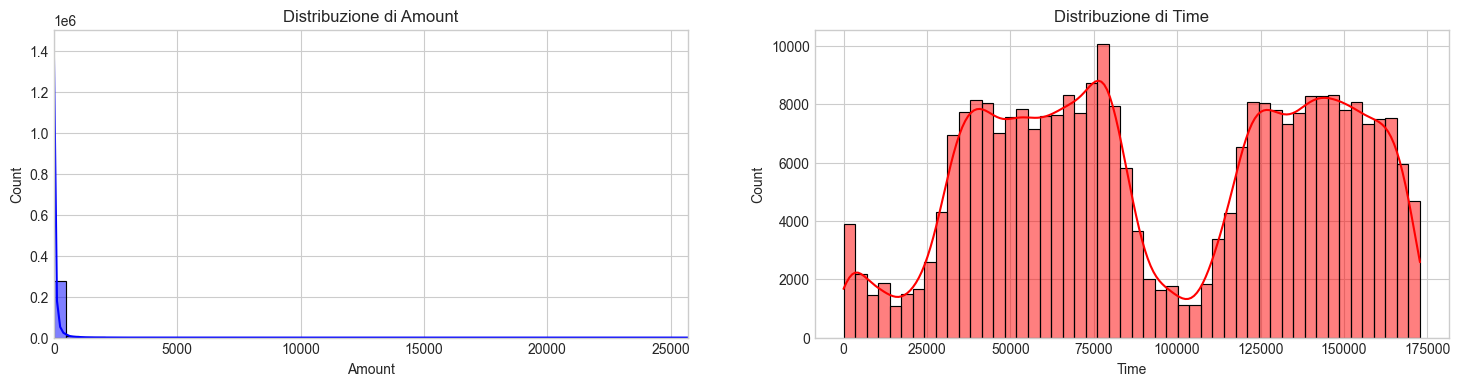

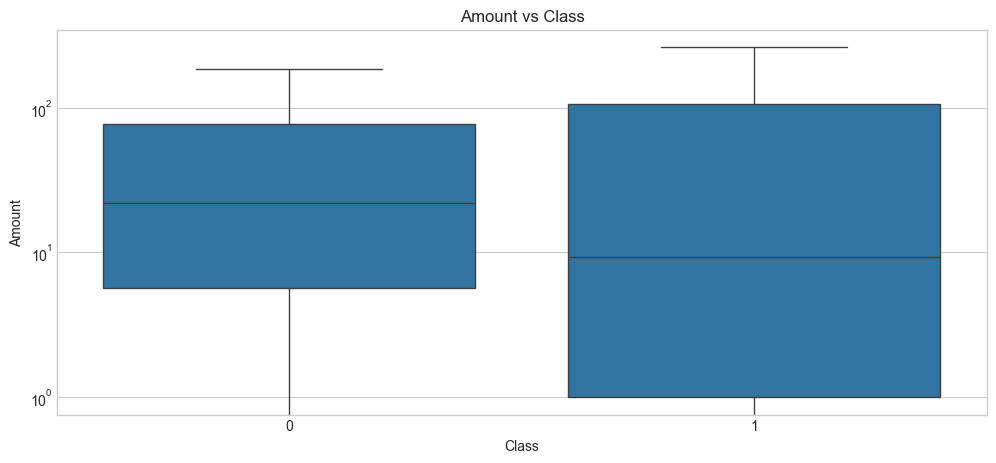

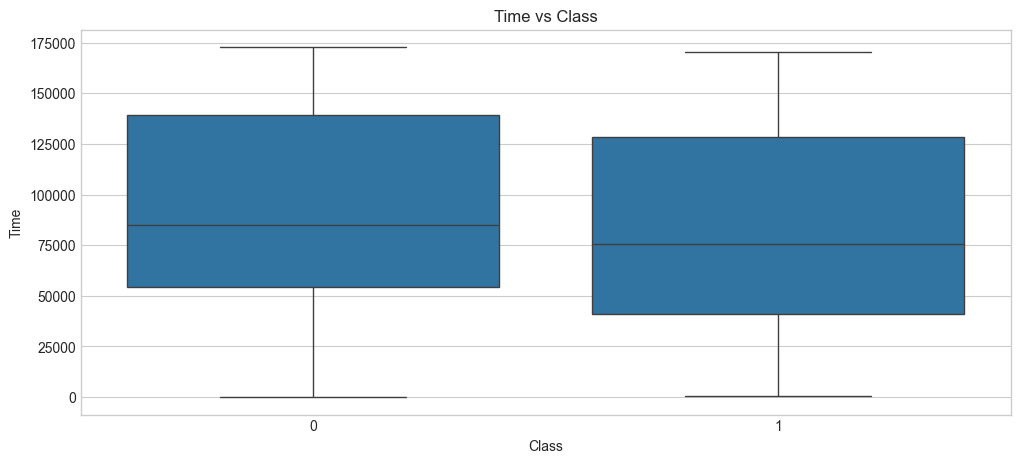

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

sns.histplot(df['Amount'], ax=ax[0], color='b', bins=50, kde=True)
ax[0].set_title('Distribuzione di Amount')
ax[0].set_xlim([min(df['Amount']), max(df['Amount'])])

sns.histplot(df['Time'], ax=ax[1], color='r', bins=50, kde=True)
ax[1].set_title('Distribuzione di Time')
plt.show()


plt.figure(figsize=(12, 5))
sns.boxplot(x='Class', y='Amount', data=df, showfliers=False) 
plt.title('Amount vs Class')
plt.yscale('log') 
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(x='Class', y='Time', data=df)
plt.title('Time vs Class')
plt.show()

**Osservazioni su `Time` e `Amount`:**

Dall'analisi grafica delle distribuzioni delle feature `Time` e `Amount`, possiamo trarre le seguenti considerazioni:

-   **Amount:**
    -   L'istogramma della feature `Amount` mostra una distribuzione fortemente asimmetrica a destra (right-skewed). Ciò indica che la maggior parte delle transazioni ha un importo relativamente piccolo, mentre un numero limitato di transazioni ha importi molto elevati (outlier).
    -   Il boxplot che confronta `Amount` per le transazioni fraudolente (`Class=1`) e quelle legittime (`Class=0`), specialmente quando visualizzato con una scala logaritmica sull'asse y per una migliore leggibilità, suggerisce che, sebbene ci sia una notevole sovrapposizione, la distribuzione degli importi per le transazioni fraudolente potrebbe avere caratteristiche leggermente diverse (ad esempio, una diversa mediana o range interquartile) rispetto a quelle legittime. Nonostante ciò, gli importi da soli non sembrano essere un discriminante forte. La rimozione degli outlier grafici (`showfliers=False`) aiuta a concentrarsi sul corpo principale delle distribuzioni.

-   **Time:**
    -   La feature `Time` rappresenta i secondi trascorsi tra ciascuna transazione e la prima transazione registrata nel dataset.
    -   L'istogramma di `Time` mostra un pattern bimodale. Questo andamento potrebbe riflettere cicli di attività giornalieri, come ad esempio una diminuzione del numero di transazioni durante le ore notturne e picchi durante le ore diurne/serali.
    -   Il boxplot che confronta `Time` per le due classi non rivela, a una prima analisi, pattern immediatamente evidenti o distintivi che possano separare nettamente le frodi dalle transazioni legittime basandosi unicamente su questa feature grezza. Anche se si potrebbe notare una leggera differenza nelle mediane o nella dispersione, la sovrapposizione è considerevole.

**Implicazioni per il Preprocessing:**
Data la natura e la scala di `Time` e `Amount` rispetto alle feature PCA (che sono già standardizzate), sarà cruciale scalarle prima di fornirle in input a modelli sensibili alla scala delle feature (come Logistic Regression, SVM, Reti Neurali). Per questo progetto, si è scelto di utilizzare `RobustScaler`, in quanto è meno sensibile agli outlier presenti nella feature `Amount` rispetto, ad esempio, a `StandardScaler`. La feature `Time`, sebbene non trasformata da PCA, non presenta la stessa problematica di outlier estremi di `Amount`, ma la sua scala è comunque differente e beneficia dello scaling.
Ulteriori analisi o feature engineering sulla feature `Time` (es. trasformazione in ora del giorno, giorno della settimana, o analisi di pattern temporali più complessi) potrebbero essere considerate in sviluppi futuri, ma per gli scopi di questo progetto ci limiteremo allo scaling.

### 4.3. Analisi delle Correlazioni
Esaminiamo la correlazione tra le features e la variabile target. Poiché le features `V1-V28` sono componenti PCA, ci aspettiamo che siano largamente incorrelate tra loro. La correlazione con la classe target può invece darci indicazioni sulle features potenzialmente più informative.

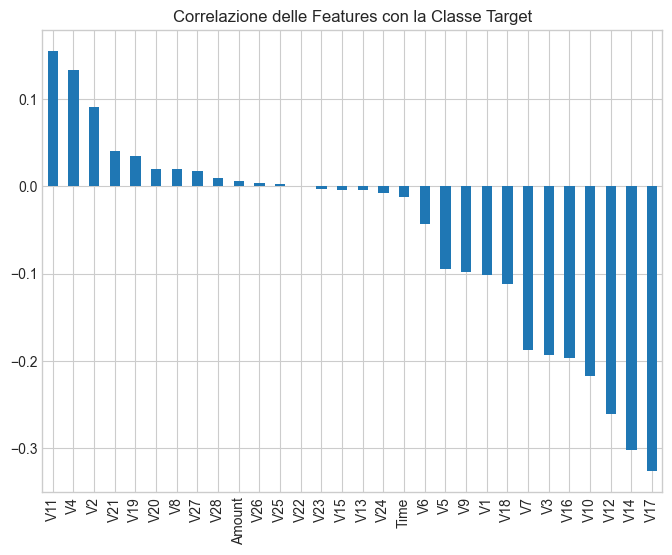

In [24]:
# Correlazione con la variabile target 'Class'
correlation_with_target = df.corr()['Class'].sort_values(ascending=False)
plt.figure(figsize=(8, 6))
correlation_with_target.drop('Class').plot(kind='bar')
plt.title('Correlazione delle Features con la Classe Target')
plt.show()

**Osservazioni sulle Correlazioni:**

Il grafico a barre (generato dalla cella di codice 5) visualizza le correlazioni di Pearson tra ciascuna feature e la variabile target `Class`. Queste correlazioni ci forniscono una prima indicazione quantitativa della relazione lineare tra le singole feature e la probabilità che una transazione sia fraudolenta.

-   **Correlazioni Negative Marcate:**
    Alcune features PCA, in particolare `V17`, `V14`, `V12`, e `V10`, mostrano una correlazione negativa relativamente più marcata con la classe `Class`. Questo suggerisce che valori più bassi (o più negativi, data la natura delle componenti PCA) di queste features sono associati a una maggiore probabilità che la transazione sia una frode. Ad esempio, `V17` ha la correlazione negativa più forte.

-   **Correlazioni Positive Marcate:**
    Altre features PCA, come `V11`, `V4`, e `V2`, mostrano una correlazione positiva con la classe `Class`. Questo indica che valori più alti di queste features potrebbero essere associati a una maggiore probabilità di frode. `V11` spicca con la correlazione positiva più forte.

-   **Correlazioni Deboli:**
    Le feature `Amount` e `Time` mostrano correlazioni lineari molto deboli con `Class`. Questo è un risultato atteso per `Amount`, data la sua ampia e sovrapposta distribuzione vista in precedenza. Per `Time`, la debole correlazione lineare non esclude la possibilità di relazioni non lineari o pattern temporali più complessi che potrebbero essere utili (ma che non esploreremo in dettaglio in questo progetto oltre lo scaling). Anche molte altre features PCA (`V20` a `V28`, `V1` a `V9` con alcune eccezioni) hanno correlazioni vicine allo zero.

**Implicazioni:**
Le features con correlazioni (positive o negative) di magnitudine maggiore sono candidati promettenti per essere informative nei modelli di classificazione. Tuttavia, è importante ricordare che:
1.  La correlazione di Pearson misura solo relazioni lineari.
2.  Le features PCA sono combinazioni lineari delle feature originali (sconosciute) e, sebbene siano ortogonali tra loro, la loro correlazione individuale con il target non racconta l'intera storia. Interazioni tra feature potrebbero essere cruciali.
3.  Modelli più complessi (come Random Forest e XGBoost) sono in grado di catturare relazioni non lineari e interazioni che questa semplice analisi di correlazione potrebbe non evidenziare.

Nonostante ciò, questa analisi fornisce una prima scrematura utile e conferma che alcune delle componenti PCA contengono segnale rilevante per la distinzione tra frodi e transazioni legittime.

### 4.4. Distribuzione di Alcune Features PCA per Classe
Visualizziamo le distribuzioni di densità (KDE) per alcune delle features PCA che hanno mostrato una correlazione più significativa con la classe target, separando le transazioni legittime da quelle fraudolente. Questo può aiutarci a capire se ci sono differenze visibili nelle distribuzioni.

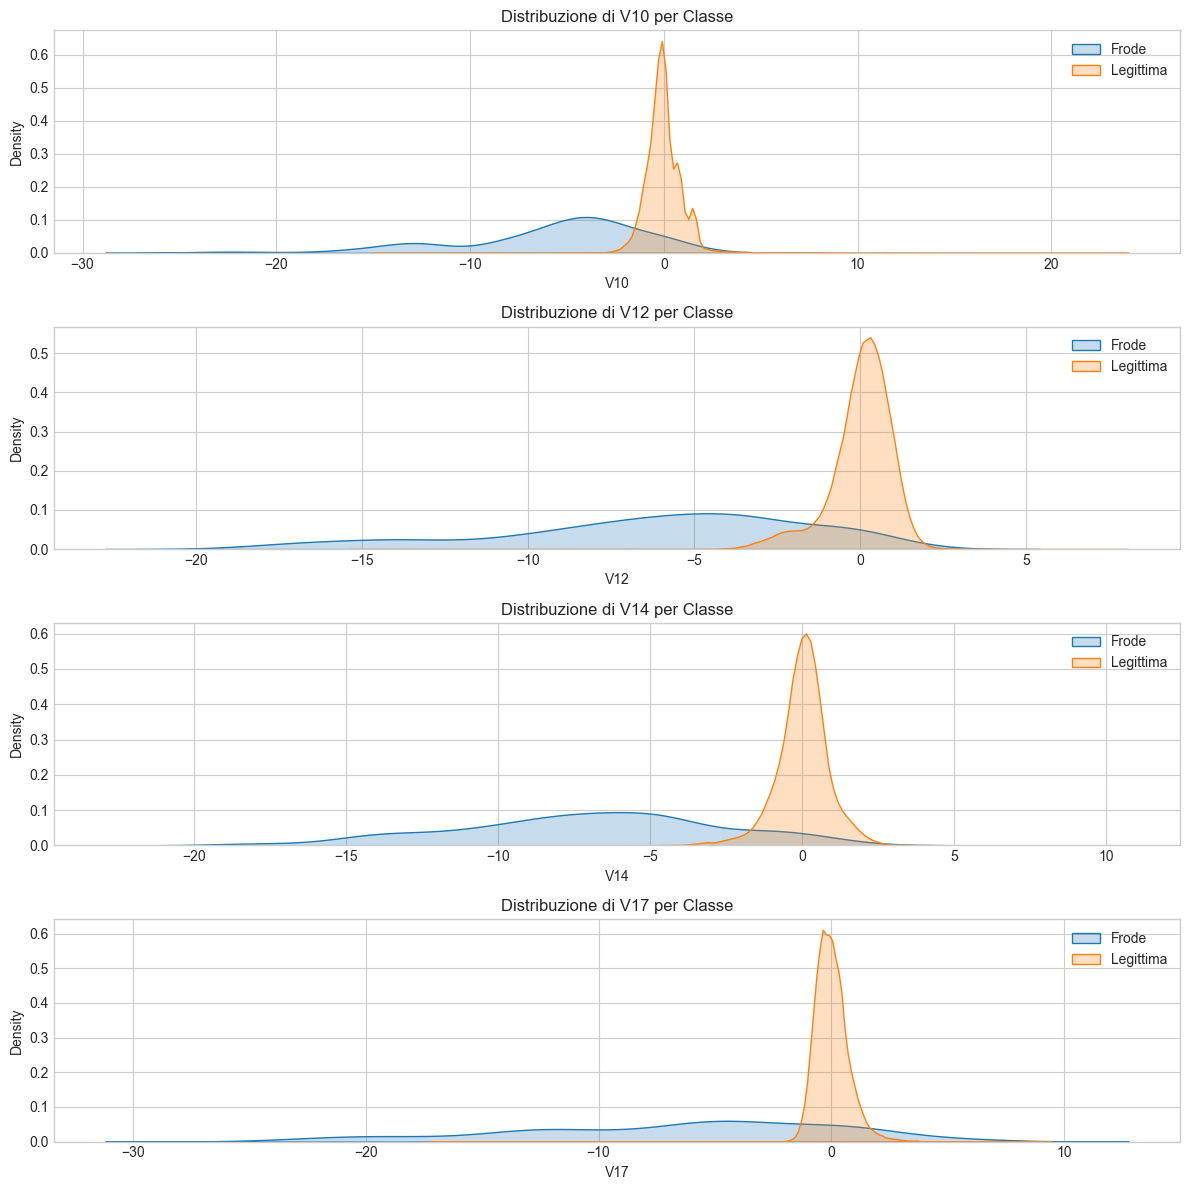

In [ ]:
var_to_plot = ['V10', 'V12', 'V14', 'V17']
plt.figure(figsize=(12, len(var_to_plot)*3))
for i, var in enumerate(var_to_plot):
    plt.subplot(len(var_to_plot), 1, i+1)
    sns.kdeplot(df[var][df.Class == 1], label="Frode", fill=True)
    sns.kdeplot(df[var][df.Class == 0], label="Legittima", fill=True)
    plt.title(f'Distribuzione di {var} per Classe')
    plt.legend()
plt.tight_layout()
plt.show()

## 5. Preparazione dei Dati per il Machine Learning

Questa fase è cruciale per garantire che i dati siano in un formato ottimale per l'addestramento dei modelli di machine learning. Include diversi passaggi chiave:

1.  **Scaling delle Features `Time` e `Amount`**:
    * **Motivazione**: Come osservato nell'EDA, le features `Time` e `Amount` hanno scale e distribuzioni molto diverse rispetto alle features PCA (`V1-V28`), che sono già il risultato di una standardizzazione (media zero, varianza unitaria). Modelli come la Regressione Logistica e le Support Vector Machines sono sensibili alla scala delle feature di input. Se non scalate, le feature con valori numerici maggiori potrebbero dominare il processo di apprendimento, portando a performance subottimali o a coefficienti difficili da interpretare.
    * **Metodo Scelto**: Si è utilizzato `RobustScaler` da `sklearn.preprocessing`. Questo scaler rimuove la mediana e scala i dati in base al range interquartile (IQR). La scelta di `RobustScaler` è particolarmente indicata per `Amount`, che presenta outlier significativi, in quanto è meno influenzato da questi valori estremi rispetto a `StandardScaler` (che usa media e deviazione standard) o `MinMaxScaler`. Sebbene `Time` non presenti outlier così estremi, scalarla con `RobustScaler` garantisce coerenza e robustezza.
    * **Applicazione**: `RobustScaler` viene *fittato* **solo** sul training set (`X_train_orig`) per calcolare mediana e IQR, e poi utilizzato per *trasformare* sia il training set che il test set (`X_test_orig`). Questo previene il data leakage, ovvero l'introduzione di informazioni dal test set nel processo di fittaggio dello scaler. Gli scaler fittati (`scaler_amount` e `scaler_time`) vengono salvati per poterli riutilizzare in modo consistente su nuovi dati (ad esempio, in un ambiente di produzione).

2.  **Separazione Features e Target**:
    * Si sono già implicitamente separate le features (`X_original`) dalla variabile target (`y_original`) dopo il caricamento dei dati. Questa separazione è standard per problemi di apprendimento supervisionato.

3.  **Suddivisione in Training e Test Set**:
    * **Motivazione**: È fondamentale dividere il dataset in un insieme di addestramento (su cui il modello impara) e un insieme di test (su cui il modello viene valutato in modo imparziale per stimare le sue performance su dati mai visti).
    * **Metodo Scelto**: Si è utilizzato `train_test_split` da `sklearn.model_selection` con un rapporto 80/20 (80% training, 20% test).
    * **Stratificazione**: Data la forte natura sbilanciata del target `Class`, è stato essenziale utilizzare il parametro `stratify=y_original`. Questo assicura che la proporzione di transazioni fraudolente e legittime sia mantenuta sia nel training set (`y_train_orig`) che nel test set (`y_test_orig`), garantendo che entrambi i set siano rappresentativi della distribuzione originale delle classi.

4.  **Gestione dello Sbilanciamento delle Classi (nel Training Set)**:
    * **Motivazione**: Con solo lo 0.17% di frodi, la maggior parte dei classificatori standard tenderebbe a favorire la classe maggioritaria (transazioni legittime), ottenendo un'alta accuracy ma fallendo nel rilevare le frodi (basso recall per la classe frode).
    * **Metodo Scelto**: Si applicherà la tecnica SMOTE (Synthetic Minority Over-sampling Technique) da `imblearn.over_sampling`. SMOTE funziona creando campioni sintetici per la classe minoritaria (frodi) basandosi sui suoi vicini più prossimi nello spazio delle feature. Questo aiuta a bilanciare la distribuzione delle classi nel training set, permettendo al modello di apprendere meglio le caratteristiche distintive delle frodi.
    * **Applicazione Cruciale**: È di fondamentale importanza applicare SMOTE **solo e unicamente sul training set (`X_train_prepared`, `y_train_orig`) e <em>dopo</em> la suddivisione iniziale in training e test**. Applicare SMOTE prima dello split o sull'intero dataset (incluso il test set) porterebbe a data leakage: il modello verrebbe addestrato (o il test set contaminato) con informazioni sintetiche che sono derivate anche da campioni che finiranno nel test set, portando a una stima eccessivamente ottimistica delle performance. Il test set (`X_test_prepared`, `y_test`) deve rimanere "incontaminato" e riflettere la distribuzione reale dei dati per una valutazione onesta.

Dopo questi passaggi, avremo `X_train_prepared` e `X_test_prepared` (con `Time` e `Amount` scalate e le originali rimosse), e `y_train_orig` e `y_test` (che è una copia di `y_test_orig`). Il training set (`X_train_prepared`, `y_train_orig`) sarà ulteriormente processato con SMOTE prima di addestrare ciascun modello.

In [ ]:
scaler_amount = RobustScaler()
X_train_scaled_amount = scaler_amount.fit_transform(X_train_orig['Amount'].values.reshape(-1, 1))
X_test_scaled_amount = scaler_amount.transform(X_test_orig['Amount'].values.reshape(-1, 1))
joblib.dump(scaler_amount, 'scaler_amount.joblib')
print("Scaler per Amount (fittato su X_train originale) salvato in: scaler_amount.joblib")

scaler_time = RobustScaler()
X_train_scaled_time = scaler_time.fit_transform(X_train_orig['Time'].values.reshape(-1, 1))
X_test_scaled_time = scaler_time.transform(X_test_orig['Time'].values.reshape(-1, 1))
joblib.dump(scaler_time, 'scaler_time.joblib')
print("Scaler per Time (fittato su X_train originale) salvato in: scaler_time.joblib")

X_train_prepared = X_train_orig.copy()
X_test_prepared = X_test_orig.copy()

X_train_prepared['scaled_amount'] = X_train_scaled_amount
X_train_prepared['scaled_time'] = X_train_scaled_time
X_test_prepared['scaled_amount'] = X_test_scaled_amount
X_test_prepared['scaled_time'] = X_test_scaled_time

X_train_prepared.drop(['Time', 'Amount'], axis=1, inplace=True)
X_test_prepared.drop(['Time', 'Amount'], axis=1, inplace=True)

print("\nDataset di training preparato (prime righe):")
print(X_train_prepared.head())
print(f"Forma di X_train_prepared: {X_train_prepared.shape}")

print("\nDataset di test preparato (prime righe):")
print(X_test_prepared.head())
print(f"Forma di X_test_prepared: {X_test_prepared.shape}")

Scaler per Amount (fittato su X_train originale) salvato in: scaler_amount.joblib
Scaler per Time (fittato su X_train originale) salvato in: scaler_time.joblib

Dataset di training preparato (prime righe):
              V1        V2        V3        V4        V5        V6        V7  \
265518  1.946747 -0.752526 -1.355130 -0.661630  1.502822  4.024933 -1.479661   
180305  2.035149 -0.048880 -3.058693  0.247945  2.943487  3.298697 -0.002192   
42664  -0.991920  0.603193  0.711976 -0.992425 -0.825838  1.956261 -2.212603   
198723  2.285718 -1.500239 -0.747565 -1.668119 -1.394143 -0.350339 -1.427984   
82325  -0.448747 -1.011440  0.115903 -3.454854  0.715771 -0.147490  0.504347   

              V8        V9       V10  ...       V21       V22       V23  \
265518  1.139880  1.406819 -0.157403  ...  0.076197  0.297537  0.307915   
180305  0.674782  0.045826  0.284864  ...  0.038628  0.228197  0.035542   
42664  -5.037523  0.000772 -2.009561  ... -2.798352  0.109526 -0.436530   
198723  0.010

## 6. Addestramento e Validazione dei Modelli di Classificazione

In questa sezione, si addestrano e si valutano tre diversi modelli di classificazione:

1.  **Regressione Logistica con regolarizzazione L1 (LASSO)**: Un modello lineare di base, ma con regolarizzazione L1 che può aiutare nella feature selection e prevenire l'overfitting. Verrà esplorata anche in combinazione con feature polinomiali per catturare possibili non linearità.
2.  **Random Forest Classifier**: Un modello basato su ensemble di alberi decisionali, generalmente robusto e capace di catturare interazioni complesse.
3.  **XGBoost Classifier**: Un'implementazione ottimizzata e potente di gradient boosting, spesso tra i modelli più performanti in molteplici task di classificazione.

Per la valutazione, data la natura sbilanciata del dataset, ci concentreremo su metriche come:

-   **Precision (per la classe frode)**: Di tutte le transazioni predette come frode, quante lo sono realmente? (TP / (TP + FP))
-   **Recall (per la classe frode)**: Di tutte le transazioni fraudolente reali, quante sono state identificate correttamente? (TP / (TP + FN)) - Questa è spesso la metrica più importante in questo contesto, poiché mancare una frode (Falso Negativo) è solitamente più costoso di un falso allarme (Falso Positivo).
-   **F1-Score (per la classe frode)**: La media armonica di Precision e Recall, utile per bilanciare le due.
-   **AUC-ROC (Area Under the Receiver Operating Characteristic Curve)**: Misura la capacità del modello di distinguere tra le classi attraverso varie soglie.
-   **AUC-PR (Area Under the Precision-Recall Curve)**: Particolarmente informativa per dataset sbilanciati, rappresenta la media delle precision a diversi valori di soglia ed è spesso preferita all'AUC-ROC in contesti di forte sbilanciamento.
-   **Confusion Matrix**: Per visualizzare il numero di Veri Positivi (TP), Falsi Positivi (FP), Veri Negativi (TN) e Falsi Negativi (FN).

Definiamo prima una funzione ausiliaria per calcolare e visualizzare queste metriche, che verrà riutilizzata per ciascun modello.

In [ ]:

def evaluate_model(y_true, y_pred, y_pred_proba=None, model_name="Modello"):
    print(f"--- Valutazione: {model_name} ---")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision (Fraud): {precision_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"Recall (Fraud): {recall_score(y_true, y_pred, pos_label=1):.4f}") 
    print(f"F1-Score (Fraud): {f1_score(y_true, y_pred, pos_label=1):.4f}")  
    if y_pred_proba is not None:
        print(f"ROC AUC Score: {roc_auc_score(y_true, y_pred_proba[:, 1]):.4f}")
        avg_precision = average_precision_score(y_true, y_pred_proba[:, 1], pos_label=1)
        print(f"Average Precision (AUC-PR): {avg_precision:.4f}") 
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predetto')
    plt.ylabel('Reale')
    plt.title('Confusion Matrix')
    plt.show()
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Legittima (0)', 'Frode (1)']))
    print("--------------------------------------\n")

    return {
        'model': model_name,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_fraud': precision_score(y_true, y_pred, pos_label=1, zero_division=0),
        'recall_fraud': recall_score(y_true, y_pred, pos_label=1, zero_division=0),
        'f1_fraud': f1_score(y_true, y_pred, pos_label=1, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_pred_proba[:, 1]) if y_pred_proba is not None else None,
        'auc_pr': average_precision_score(y_true, y_pred_proba[:, 1], pos_label=1) if y_pred_proba is not None else None
    }

model_results = []

### 6.1. Regressione Logistica 

--- Inizio Regressione LASSO Non-Lineare con Pre-Selezione Feature e Ottimizzazione Iperparametri ---

--- Esecuzione Pre-Selezione Feature con RandomForestClassifier ---
Numero di feature selezionate inizialmente: 10
Feature selezionate: ['V2', 'V7', 'V16', 'V3', 'V12', 'V11', 'V17', 'V10', 'V4', 'V14']

Caricamento iperparametri per LASSO LogReg Polinomiale (FS) da 'best_lasso_logreg_poly_fs10_hyperparams.json'...
Iperparametri LASSO LogReg Polinomiale (FS) caricati: {'lasso_logreg__C': 0.003727593720314938}

--- Addestramento Pipeline LASSO LogReg Polinomiale (FS) con Iperparametri Ottimali Caricati ---
Pipeline LASSO LogReg Polinomiale (FS) addestrata con iperparametri caricati.

--- Valutazione LASSO LogReg Polinomiale Ottimizzato (FS, Pipeline) - Soglia Default 0.5 ---
--- Valutazione: LASSO LogReg (PolyDeg2, 10PreSelFeat, SMOTE, C=0.0037, Th=0.5) ---
Accuracy: 0.9749
Precision (Fraud): 0.0594
Recall (Fraud): 0.9184
F1-Score (Fraud): 0.1117
ROC AUC Score: 0.9745
Average Precision

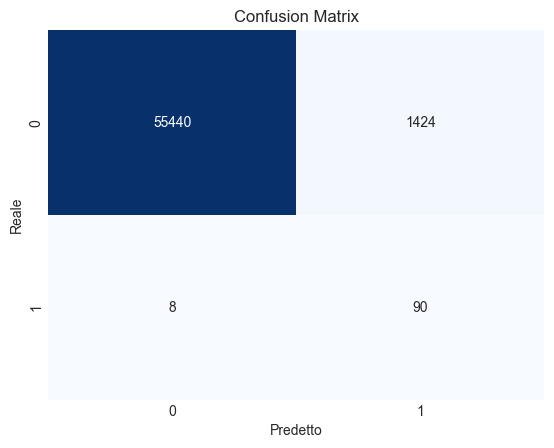


Classification Report:
               precision    recall  f1-score   support

Legittima (0)       1.00      0.97      0.99     56864
    Frode (1)       0.06      0.92      0.11        98

     accuracy                           0.97     56962
    macro avg       0.53      0.95      0.55     56962
 weighted avg       1.00      0.97      0.99     56962

--------------------------------------

Modello LASSO LogReg Polinomiale Ottimizzato (FS) e colonne input pre-selezionate salvati.


In [ ]:


print("--- Inizio Regressione LASSO Non-Lineare con Pre-Selezione Feature e Ottimizzazione Iperparametri ---")

# --- 1. Pre-Selezione Feature Iniziale con RandomForestClassifier ---
print("\n--- Esecuzione Pre-Selezione Feature con RandomForestClassifier ---")
rf_for_selection = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    class_weight='balanced_subsample',
    n_jobs=-1 
)
rf_for_selection.fit(X_train_prepared, y_train_orig)

N_FEATURES_TO_PRESELECT = 10 
importances = rf_for_selection.feature_importances_
selected_indices = np.argsort(importances)[-N_FEATURES_TO_PRESELECT:]
selected_feature_names_initial = X_train_prepared.columns[selected_indices].tolist()

X_train_fs = X_train_prepared[selected_feature_names_initial]
X_test_fs = X_test_prepared[selected_feature_names_initial]

print(f"Numero di feature selezionate inizialmente: {len(selected_feature_names_initial)}")
print(f"Feature selezionate: {selected_feature_names_initial}")

# --- 2. Definizione della Pipeline per Regressione Logistica LASSO  ---
pipeline_lasso_poly = ImbPipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('lasso_logreg', LogisticRegression(
        penalty='l1', 
        solver='liblinear', 
        random_state=42, 
        max_iter=1500, 
        tol=0.001
    ))
])

# --- 3. Definizione della Griglia di Iperparametri per GridSearchCV ---
param_grid_lasso_logreg = {
    'lasso_logreg__C': np.logspace(-3, 1, 8) 
}

# --- 4. Setup e Esecuzione di GridSearchCV ---
cv_stratified_lasso = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search_lasso_poly = GridSearchCV(
    estimator=pipeline_lasso_poly,
    param_grid=param_grid_lasso_logreg,
    scoring='average_precision',
    cv=cv_stratified_lasso,
    verbose=1,
    n_jobs=-1
)

hyperparams_filename_lasso_poly = f'best_LR_C.json'
FORCE_NEW_SEARCH_LASSO_POLY = False 
best_lasso_poly_model_pipeline = None

if not FORCE_NEW_SEARCH_LASSO_POLY and os.path.exists(hyperparams_filename_lasso_poly):
    print(f"\nCaricamento iperparametri per LASSO LogReg Polinomiale (FS) da '{hyperparams_filename_lasso_poly}'...")
    with open(hyperparams_filename_lasso_poly, 'r') as f:
        best_lasso_params_loaded = json.load(f)
    print(f"Iperparametri LASSO LogReg Polinomiale (FS) caricati: {best_lasso_params_loaded}")

    pipeline_lasso_poly.set_params(**best_lasso_params_loaded)
    print(f"\n--- Addestramento Pipeline LASSO LogReg Polinomiale (FS) con Iperparametri Ottimali Caricati ---")
    pipeline_lasso_poly.fit(X_train_fs, y_train_orig) 
    best_lasso_poly_model_pipeline = pipeline_lasso_poly
    print("Pipeline LASSO LogReg Polinomiale (FS) addestrata con iperparametri caricati.")
else:
    if FORCE_NEW_SEARCH_LASSO_POLY:
         print(f"\nFORCE_NEW_SEARCH_LASSO_POLY è True. Esecuzione di una nuova GridSearchCV...")
    else:
        print(f"\nFile iperparametri '{hyperparams_filename_lasso_poly}' non trovato. Esecuzione di GridSearchCV...")

    print(f"\nInizio Grid Search per Pipeline LASSO LogReg Polinomiale (FS, scoring='average_precision')...")
    grid_search_lasso_poly.fit(X_train_fs, y_train_orig) 

    best_lasso_params_found = grid_search_lasso_poly.best_params_
    print(f"\nMigliori parametri trovati: {best_lasso_params_found}")
    print(f"Miglior score AUC-PR (CV): {grid_search_lasso_poly.best_score_:.4f}")

    with open(hyperparams_filename_lasso_poly, 'w') as f:
        json.dump(best_lasso_params_found, f, indent=4)
    print(f"Migliori iperparametri salvati in '{hyperparams_filename_lasso_poly}'")
    best_lasso_poly_model_pipeline = grid_search_lasso_poly.best_estimator_

# --- 5. Valutazione del modello con soglia di default 0.5 ---
print(f"\n--- Valutazione LASSO LogReg Polinomiale Ottimizzato (FS, Pipeline) - Soglia Default 0.5 ---")
# Predizioni binarie (con soglia default 0.5)
y_pred_lasso_default_thresh = best_lasso_poly_model_pipeline.predict(X_test_fs)
# Probabilità predette (necessarie per AUC-ROC, AUC-PR e tuning soglia)
y_pred_proba_lasso = best_lasso_poly_model_pipeline.predict_proba(X_test_fs)

optimal_C_lasso = best_lasso_poly_model_pipeline.named_steps['lasso_logreg'].C
model_name_lasso_poly_default = ( 
    f"LASSO LogReg (PolyDeg2, {len(selected_feature_names_initial)}PreSelFeat, SMOTE, "
    f"C={optimal_C_lasso:.4f}, Th=0.5)"
)

results_lasso_default = evaluate_model(
    y_test,
    y_pred_lasso_default_thresh,
    y_pred_proba_lasso, 
    model_name_lasso_poly_default
)

model_results = [res for res in model_results if not res['model'].startswith("LASSO LogReg (PolyDeg2")]
model_results.append(results_lasso_default)

joblib.dump(best_lasso_poly_model_pipeline, f'LR_model.joblib')
joblib.dump(selected_feature_names_initial, f'LR_columns.joblib')
print(f"Modello LASSO LogReg Polinomiale Ottimizzato (FS) e colonne input pre-selezionate salvati.")

### Analisi della Soglia di Classificazione e Curva Precision-Recall per LASSO LogReg Polinomiale

Dopo aver addestrato il nostro modello LASSO LogReg Polinomiale ottimizzato con GridSearchCV (utilizzando 10 feature pre-selezionate e SMOTE nella pipeline), la valutazione iniziale è stata effettuata con la soglia di classificazione di default (tipicamente 0.5 sulla probabilità predetta). I risultati (visibili nell'output della cella di codice 10) hanno mostrato:
-   **Accuracy:** 0.9749
-   **Precision (Frode):** 0.0594
-   **Recall (Frode):** 0.9184
-   **F1-Score (Frode):** 0.1117
-   **AUC-PR:** 0.7898

Come si può notare, con la soglia di default, il modello ha un **Recall molto alto (0.9184)** per le frodi, il che significa che identifica correttamente la maggior parte delle frodi reali. Tuttavia, la **Precision è estremamente bassa (0.0594)**, indicando un numero molto elevato di falsi positivi (transazioni legittime erroneamente segnalate come frode). Questo scenario, sebbene catturi molte frodi, potrebbe non essere pratico a causa dell'alto costo associato alla gestione dei falsi allarmi.

Per problemi con classi sbilanciate, la soglia di default raramente rappresenta il miglior compromesso. La **Curva Precision-Recall (P-R Curve)**, generata nella cella di codice 11, visualizza la precisione rispetto al recall per diverse soglie. L'obiettivo è trovare una soglia che offra un bilanciamento più accettabile.

Nella cella seguente si calcola la soglia che massimizza l'**F1-Score** (media armonica di Precision e Recall).


--- Analisi Precision-Recall e Tuning Soglia per LASSO LogReg Polinomiale Ottimizzato (FS) ---


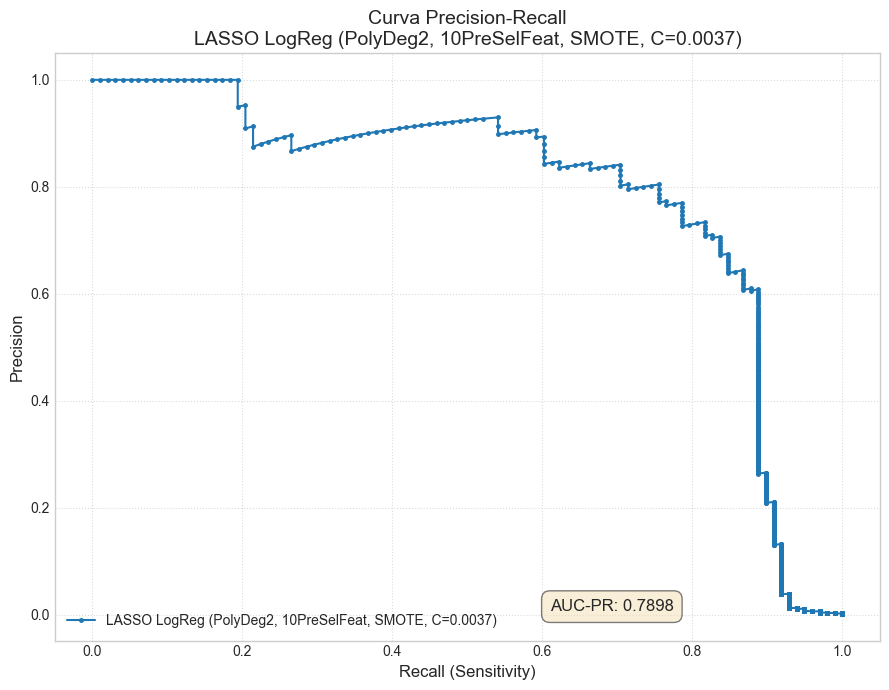


Soglia che massimizza F1-Score (basata sulla curva P-R): 0.9983
  Con questa soglia -> Precision: 0.8043, Recall: 0.7551, F1-Score: 0.7789
Soglia ottimale (0.9983) salvata in 'LR_thresh.json'

--- Valutazione con Soglia Ottimizzata per F1 (0.9983) ---
--- Valutazione: LASSO LogReg (PolyDeg2, 10PreSelFeat, SMOTE, C=0.0037, Th=0.9983) ---
Accuracy: 0.9993
Precision (Fraud): 0.8043
Recall (Fraud): 0.7551
F1-Score (Fraud): 0.7789
ROC AUC Score: 0.9745
Average Precision (AUC-PR): 0.7898

Confusion Matrix:


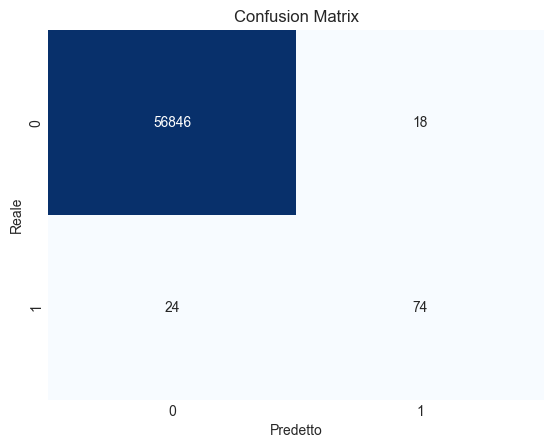


Classification Report:
               precision    recall  f1-score   support

Legittima (0)       1.00      1.00      1.00     56864
    Frode (1)       0.80      0.76      0.78        98

     accuracy                           1.00     56962
    macro avg       0.90      0.88      0.89     56962
 weighted avg       1.00      1.00      1.00     56962

--------------------------------------


Numero di feature polinomiali con coeff. non nullo nel LASSO LogReg ottimizzato: 55
Prime 10 feature polinomiali (valore assoluto coeff.) nel LASSO LogReg:
V4        1.765615
V14       1.063791
V2^2      0.829854
V12       0.734075
V7^2      0.550469
V10       0.535965
V7 V11    0.498178
V16 V3    0.496813
V7 V4     0.491232
V4^2      0.490574
dtype: float64

--- Fine Regressione LASSO Non-Lineare con Pre-Selezione Feature e Analisi Soglia ---


In [ ]:
print("\n--- Analisi Precision-Recall e Tuning Soglia per LASSO LogReg Polinomiale Ottimizzato (FS) ---")

# Estrarre le probabilità per la classe positiva (frode, classe 1)
y_pred_proba_fraud = y_pred_proba_lasso[:, 1] 

precision_vals, recall_vals, thresholds_prc = precision_recall_curve(y_test, y_pred_proba_fraud, pos_label=1)

# Plot della curva Precision-Recall
fig_prc, ax_prc = plt.subplots(figsize=(9, 7))
model_plot_label = (
    f"LASSO LogReg (PolyDeg2, {len(selected_feature_names_initial)}PreSelFeat, SMOTE, "
    f"C={optimal_C_lasso:.4f})"
)
ax_prc.plot(recall_vals, precision_vals, marker='.', markersize=5, linestyle='-', linewidth=1.5, label=model_plot_label)
ax_prc.set_xlabel('Recall (Sensitivity)', fontsize=12)
ax_prc.set_ylabel('Precision', fontsize=12)
ax_prc.set_title(f'Curva Precision-Recall\n{model_plot_label}', fontsize=14)
ax_prc.legend(fontsize=10, loc='lower left')
ax_prc.grid(True, linestyle=':', alpha=0.7)
auc_pr_score_for_plot = average_precision_score(y_test, y_pred_proba_fraud, pos_label=1)
ax_prc.text(0.6, 0.05, f'AUC-PR: {auc_pr_score_for_plot:.4f}', transform=ax_prc.transAxes, fontsize=12, 
            bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))
plt.tight_layout()
plt.show()
plt.close(fig_prc) 

# Inizializza threshold_for_max_f1 a None o un valore di default
threshold_for_max_f1 = None 

# Trova la soglia che massimizza l'F1-score sulla base della curva PR
if len(thresholds_prc) > 0:

    f1_scores_on_prc = (2 * precision_vals[:len(thresholds_prc)] * recall_vals[:len(thresholds_prc)]) / \
                       (precision_vals[:len(thresholds_prc)] + recall_vals[:len(thresholds_prc)] + 1e-9) # Evita divisione per zero
    
    if len(f1_scores_on_prc) > 0: 
        idx_max_f1 = np.argmax(f1_scores_on_prc)
        threshold_for_max_f1 = thresholds_prc[idx_max_f1]

        print(f"\nSoglia che massimizza F1-Score (basata sulla curva P-R): {threshold_for_max_f1:.4f}")
        print(f"  Con questa soglia -> Precision: {precision_vals[idx_max_f1]:.4f}, Recall: {recall_vals[idx_max_f1]:.4f}, F1-Score: {f1_scores_on_prc[idx_max_f1]:.4f}")

        # --- MODIFICA: SALVATAGGIO DELLA SOGLIA OTTIMALE ---
        threshold_to_save_content = {'thresh': threshold_for_max_f1}
        threshold_output_filename = "LR_thresh.json" 
        try:
            with open(threshold_output_filename, 'w') as f:
                json.dump(threshold_to_save_content, f, indent=4)
            print(f"Soglia ottimale ({threshold_for_max_f1:.4f}) salvata in '{threshold_output_filename}'")
        except Exception as e:
            print(f"Errore durante il salvataggio della soglia in '{threshold_output_filename}': {e}")

        y_pred_optimized_thresh = (y_pred_proba_fraud >= threshold_for_max_f1).astype(int)
        
        model_name_lasso_poly_optimized_thresh = (
            f"LASSO LogReg (PolyDeg2, {len(selected_feature_names_initial)}PreSelFeat, SMOTE, "
            f"C={optimal_C_lasso:.4f}, Th={threshold_for_max_f1:.4f})"
        )
        
        print(f"\n--- Valutazione con Soglia Ottimizzata per F1 ({threshold_for_max_f1:.4f}) ---")

        results_lasso_optimized_thresh = evaluate_model(
            y_test,
            y_pred_optimized_thresh, 
            y_pred_proba_lasso,     
            model_name_lasso_poly_optimized_thresh
        )
        model_results.append(results_lasso_optimized_thresh)
        
    else: # len(f1_scores_on_prc) == 0
        print("Attenzione: Non è stato possibile calcolare F1-scores validi dalla curva P-R.")
        print("La soglia ottimale non può essere determinata automaticamente in questo modo.")

else: # len(thresholds_prc) == 0
    print("Attenzione: Nessuna soglia trovata nella curva Precision-Recall (precision_recall_curve).")
    print("Questo può accadere se le probabilità predette non offrono variazioni sufficienti o se ci sono pochi campioni di una classe.")


if best_lasso_poly_model_pipeline: 
    final_lasso_logreg_step = best_lasso_poly_model_pipeline.named_steps['lasso_logreg']
    final_poly_step = best_lasso_poly_model_pipeline.named_steps['poly']
    try:
        poly_feature_names_final = final_poly_step.get_feature_names_out(selected_feature_names_initial)
        lasso_logreg_coeffs = pd.Series(final_lasso_logreg_step.coef_[0], index=poly_feature_names_final)
        selected_lasso_logreg_features = lasso_logreg_coeffs[lasso_logreg_coeffs != 0]
        print(f"\nNumero di feature polinomiali con coeff. non nullo nel LASSO LogReg ottimizzato: {len(selected_lasso_logreg_features)}")
        if len(selected_lasso_logreg_features) > 0:
            print("Prime 10 feature polinomiali (valore assoluto coeff.) nel LASSO LogReg:")
            print(selected_lasso_logreg_features.abs().sort_values(ascending=False).head(10))
        else:
            print("Nessuna feature selezionata da LASSO LogReg (tutti i coefficienti sono zero).")
    except Exception as e:
        print(f"Errore nell'ottenere i nomi delle feature polinomiali o coefficienti per LASSO LogReg: {e}")

print("\n--- Fine Regressione LASSO Non-Lineare con Pre-Selezione Feature e Analisi Soglia ---")

Questa soglia è risultata essere circa **0.9983**.
Rivalutando il modello con questa nuova soglia "ottimale", abbiamo ottenuto:
-   **Accuracy:** 0.9993 (aumentata)
-   **Precision (Frode):** 0.8043 (aumentata drasticamente)
-   **Recall (Frode):** 0.7551 (diminuita, come atteso, ma ancora buona)
-   **F1-Score (Frode):** 0.7789 (aumentato significativamente)

**Osservazioni sull'Impatto della Soglia:**
-   Alzando la soglia da ~0.5 a ~0.9983, la **Precision per le frodi è migliorata enormemente**, passando da circa 6% a oltre 80%. Questo significa che il numero di falsi positivi si è ridotto drasticamente.
-   Come previsto, il **Recall è diminuito** (da ~92% a ~76%), il che significa che abbiamo perso la capacità di identificare alcune frodi che prima venivano catturate.
-   Tuttavia, l'**F1-Score è migliorato notevolmente** (da 0.11 a 0.78), indicando un bilanciamento complessivamente migliore tra Precision e Recall con la nuova soglia.
-   L'AUC-ROC e l'AUC-PR rimangono invariati perché misurano la performance del modello su *tutte* le possibili soglie; il tuning della soglia seleziona solo un punto operativo su queste curve.

La scelta della soglia ottimale dipende dal contesto applicativo. Se il costo di un Falso Negativo (frode non rilevata) è estremamente alto, si potrebbe preferire una soglia più bassa per massimizzare il Recall, accettando più falsi positivi. Se, invece, il costo dei Falsi Positivi (indagare transazioni legittime) è predominante, una soglia più alta come quella trovata potrebbe essere preferibile. La massimizzazione dell'F1-score rappresenta un compromesso ragionevole.

Infine, l'analisi dei coefficienti del modello LASSO (dopo trasformazione polinomiale e scaling) ha mostrato che 55 feature polinomiali/interazioni avevano un coefficiente non nullo, indicando che il modello sta utilizzando una combinazione di queste per le sue predizioni. Le feature con i coefficienti di magnitudine assoluta più elevata (es. `V4`, `V14`, `V2^2`, `V12`) sono quelle che il modello considera più impattanti.

### 6.2. XGBoost Classifier (con Feature Selection dedicata e SMOTE)

Successivamente, esploreremo le capacità di XGBoost (Extreme Gradient Boosting), un algoritmo di machine learning basato su gradient boosting che è noto per le sue elevate performance e la sua efficienza, specialmente in competizioni di data science e in problemi di classificazione complessi.

**Strategia Adottata per XGBoost:**

1.  **Feature Selection Preliminare con `SelectFromModel`**:
    * Dato che il dataset originale contiene 28 feature PCA più `Time` e `Amount` (scalate), addestrare XGBoost su tutte le feature potrebbe essere computazionalmente intensivo e non necessariamente ottimale se alcune feature sono rumorose o poco informative.
    * Per questo motivo, eseguiremo una fase di feature selection. Addestreremo un modello XGBoost preliminare sull'intero training set preparato (`X_train_prepared`). Per gestire lo sbilanciamento delle classi *durante questa fase di stima dell'importanza delle feature*, utilizzeremo il parametro `scale_pos_weight` di XGBoost, che assegna un peso maggiore alla classe minoritaria (frodi).
    * Le feature importances calcolate da questo modello preliminare verranno poi utilizzate con `sklearn.feature_selection.SelectFromModel`. Imposteremo `threshold="median"` per selezionare le feature la cui importanza è superiore o uguale alla mediana di tutte le importanze. Questo approccio mira a conservare un sottoinsieme robusto delle feature più predittive.

2.  **Applicazione di SMOTE sul Training Set Ridotto**:
    * Una volta ottenuto il sottoinsieme di feature selezionate, applicheremo SMOTE **solo** al training set (ridotto a queste feature). Questo passaggio, come per i modelli precedenti, ha lo scopo di bilanciare le classi prima dell'addestramento del modello XGBoost finale, permettendogli di apprendere meglio le caratteristiche delle frodi.

3.  **Addestramento e Valutazione del Modello XGBoost "Base"**:
    * Il modello XGBoost finale ("base", ovvero con iperparametri di default) verrà addestrato sul training set bilanciato (con SMOTE) e contenente solo le feature selezionate.
    * Le performance verranno valutate sul test set (anch'esso ridotto alle feature selezionate ma *non* processato con SMOTE) utilizzando le metriche definite in precedenza (Precision, Recall, F1-Score per la classe frode, AUC-ROC, AUC-PR) e la confusion matrix. Verrà inoltre analizzata l'importanza delle feature del modello finale.

Questa strategia mira a combinare la potenza di XGBoost con una fase di feature selection intelligente per migliorare potenzialmente sia le performance che l'efficienza.

--- Feature Selection per XGBoost Base con SelectFromModel ---
Addestramento XGBoost preliminare per SelectFromModel (su X_train_prepared)...


/home/siralex/Desktop/CREDIT_CARD/notebooks/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Numero di feature selezionate da SelectFromModel (XGB, threshold='median'): 15
Feature selezionate per XGBoost Base: ['V4', 'V6', 'V7', 'V8', 'V10', 'V12', 'V13', 'V14', 'V18', 'V19', 'V20', 'V22', 'V26', 'V27', 'scaled_amount']
Forma di X_train_xgb_sfs_df: (227845, 15)

Applicazione SMOTE al training set (feature selezionate per XGBoost Base)...
Forma di X_train_smote_xgb_sfs: (454902, 15), y_train_smote_xgb_sfs: (454902,)
Distribuzione classi in y_train_smote_xgb_sfs:
Class
0    227451
1    227451
Name: count, dtype: int64

--- Addestramento XGBoost (Base, SelectFromModel N=15, SMOTE) ---


/home/siralex/Desktop/CREDIT_CARD/notebooks/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/siralex/Desktop/CREDIT_CARD/notebooks/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/siralex/Desktop/CREDIT_CARD/notebooks/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Valutazione: XGBoost (Base, SFM N=15, SMOTE) ---
Accuracy: 0.9985
Precision (Fraud): 0.5395
Recall (Fraud): 0.8367
F1-Score (Fraud): 0.6560
ROC AUC Score: 0.9686
Average Precision (AUC-PR): 0.8462

Confusion Matrix:


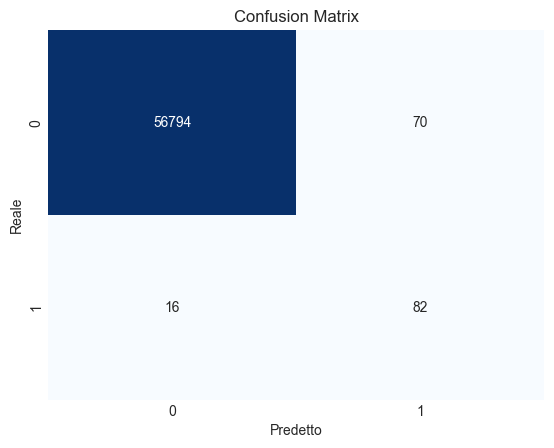


Classification Report:
               precision    recall  f1-score   support

Legittima (0)       1.00      1.00      1.00     56864
    Frode (1)       0.54      0.84      0.66        98

     accuracy                           1.00     56962
    macro avg       0.77      0.92      0.83     56962
 weighted avg       1.00      1.00      1.00     56962

--------------------------------------


Feature Importances (XGBoost Base, SFM N=15, SMOTE):
               importance
feature                  
V14              0.668655
V4               0.074386
V8               0.036522
V12              0.030746
V10              0.023435
scaled_amount    0.022941
V26              0.020234
V13              0.019783
V7               0.018930
V22              0.018180
V20              0.016120
V18              0.015148
V19              0.013023
V27              0.011870
V6               0.010027


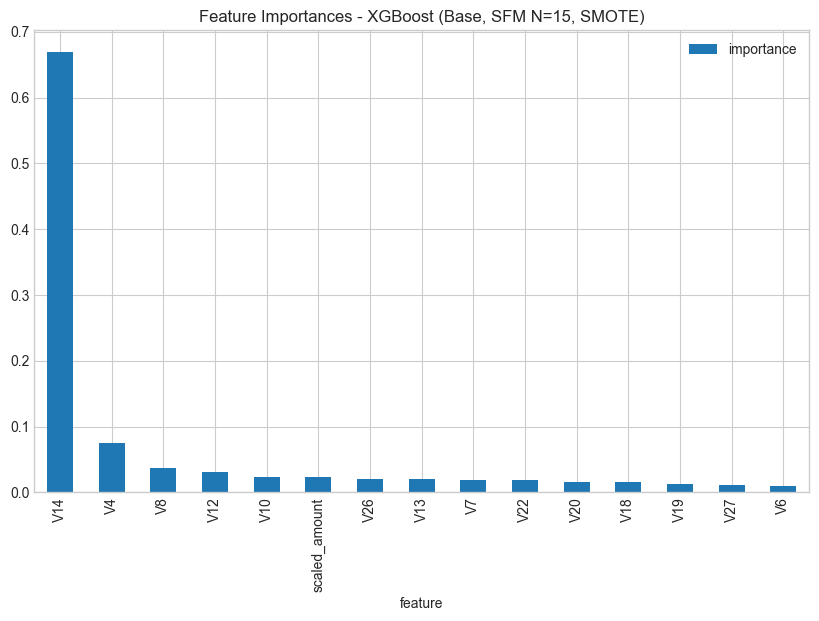

Modello XGBoost (SelectFromModel) e feature selezionate salvati.


In [ ]:

print(f"--- Feature Selection per XGBoost Base con SelectFromModel ---")

print("Addestramento XGBoost preliminare per SelectFromModel (su X_train_prepared)...")
train_orig_counts_xgb_sfs = y_train_orig.value_counts()
scale_pos_weight_xgb_sfs_estimator = train_orig_counts_xgb_sfs[0] / train_orig_counts_xgb_sfs[1] if train_orig_counts_xgb_sfs[1] > 0 else 1

xgb_estimator_for_sfs = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=scale_pos_weight_xgb_sfs_estimator
)
xgb_estimator_for_sfs.fit(X_train_prepared, y_train_orig)

# 2. Crea e fitta SelectFromModel
#    Usiamo threshold="median"
selector_xgb = SelectFromModel(
    estimator=xgb_estimator_for_sfs,
    threshold="median", # Seleziona feature con importanza >= mediana
    prefit=True
)

selected_features_xgb_sfs_mask = selector_xgb.get_support()
selected_features_xgb_sfs = X_train_prepared.columns[selected_features_xgb_sfs_mask].tolist()

print(f"\nNumero di feature selezionate da SelectFromModel (XGB, threshold='median'): {len(selected_features_xgb_sfs)}")
print(f"Feature selezionate per XGBoost Base: {selected_features_xgb_sfs}")

# 3. Applica la trasformazione ai set di training e test
X_train_xgb_sfs_data = selector_xgb.transform(X_train_prepared) # NumPy array
X_test_xgb_sfs_data = selector_xgb.transform(X_test_prepared)   # NumPy array

# Converti di nuovo in DataFrame per mantenere i nomi delle colonne
X_train_xgb_sfs_df = pd.DataFrame(X_train_xgb_sfs_data, columns=selected_features_xgb_sfs, index=X_train_prepared.index)
X_test_xgb_sfs_df = pd.DataFrame(X_test_xgb_sfs_data, columns=selected_features_xgb_sfs, index=X_test_prepared.index)

print(f"Forma di X_train_xgb_sfs_df: {X_train_xgb_sfs_df.shape}")

# 4. Applica SMOTE al training set con feature selezionate
print("\nApplicazione SMOTE al training set (feature selezionate per XGBoost Base)...")
smote_xgb_sfs = SMOTE(random_state=42)
X_train_smote_xgb_sfs, y_train_smote_xgb_sfs = smote_xgb_sfs.fit_resample(X_train_xgb_sfs_df, y_train_orig)

print(f"Forma di X_train_smote_xgb_sfs: {X_train_smote_xgb_sfs.shape}, y_train_smote_xgb_sfs: {y_train_smote_xgb_sfs.shape}")
print(f"Distribuzione classi in y_train_smote_xgb_sfs:\n{pd.Series(y_train_smote_xgb_sfs).value_counts()}")

# 5. Addestra il modello XGBoost "Base" finale
print(f"\n--- Addestramento XGBoost (Base, SelectFromModel N={len(selected_features_xgb_sfs)}, SMOTE) ---")
xgb_model_base_sfs_final = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    use_label_encoder=False,
    random_state=42
)
xgb_model_base_sfs_final.fit(X_train_smote_xgb_sfs, y_train_smote_xgb_sfs)

# 6. Valutazione
y_pred_xgb_base_sfs = xgb_model_base_sfs_final.predict(X_test_xgb_sfs_df)
y_pred_proba_xgb_base_sfs = xgb_model_base_sfs_final.predict_proba(X_test_xgb_sfs_df)

results_xgb_base_sfs = evaluate_model(
    y_test,
    y_pred_xgb_base_sfs,
    y_pred_proba_xgb_base_sfs,
    f"XGBoost (Base, SFM N={len(selected_features_xgb_sfs)}, SMOTE)"
)
model_results = [res for res in model_results if not res['model'].startswith("XGBoost Classifier (Base") and not res['model'].startswith("XGBoost (Base")]
model_results.append(results_xgb_base_sfs)

# Salva il modello e le feature selezionate
joblib.dump(xgb_model_base_sfs_final, 'XGB_model.joblib')
joblib.dump(selected_features_xgb_sfs, 'XGB_columns.joblib')
# Visualizza le feature importances del modello finale addestrato sul subset
importances_xgb_final_sfs = pd.DataFrame({
    'feature': selected_features_xgb_sfs, # Usa le feature selezionate
    'importance': xgb_model_base_sfs_final.feature_importances_
})
importances_xgb_final_sfs = importances_xgb_final_sfs.sort_values('importance', ascending=False).set_index('feature')
print(f"\nFeature Importances (XGBoost Base, SFM N={len(selected_features_xgb_sfs)}, SMOTE):")
print(importances_xgb_final_sfs.head(len(selected_features_xgb_sfs))) # Mostra tutte le feature selezionate
importances_xgb_final_sfs.plot(kind='bar', figsize=(10,6))
plt.title(f'Feature Importances - XGBoost (Base, SFM N={len(selected_features_xgb_sfs)}, SMOTE)')
plt.show()

print("Modello XGBoost (SelectFromModel) e feature selezionate salvati.")



**Osservazioni sull'XGBoost Classifier (Base, con Feature Selection e SMOTE)**

A seguito della strategia di feature selection (che ha ridotto il numero di feature a 15 utilizzando `SelectFromModel` con `threshold="median"` basato su un XGBoost preliminare) e del bilanciamento del training set con SMOTE, il modello XGBoost "base" (con iperparametri di default) ha fornito i seguenti risultati sul test set (utilizzando una soglia di classificazione di 0.5):

-   **Accuracy Complessiva:** 0.9985
-   **Metriche per la Classe Frode:**
    -   **Precision:** 0.5395
    -   **Recall:** 0.8367 (molto buono)
    -   **F1-Score:** 0.6560
-   **Metriche Globali di Discriminazione:**
    -   **ROC AUC Score:** 0.9686
    -   **Average Precision (AUC-PR):** 0.8462 (un buon indicatore per dati sbilanciati)

**Interpretazione delle Performance e Confronto:**

-   L'XGBoost base dimostra una buona capacità di **identificare una porzione significativa delle frodi reali (Recall elevato: 0.8367)**.
-   La **Precision (0.5395)**, sebbene modesta, è sostanzialmente migliore rispetto a quella del modello LASSO LogReg con soglia di default (che era 0.06). Tuttavia, indica ancora che quasi la metà delle transazioni segnalate come frode sono in realtà falsi positivi.
-   Confrontando con il modello LASSO LogReg *con soglia ottimizzata* (Recall 0.76, Precision 0.80, F1 0.78), l'XGBoost base (con soglia default) presenta un Recall superiore, ma una Precision e un F1-score inferiori.
-   L'**AUC-PR di 0.8462** è un risultato promettente e suggerisce che il modello ha una buona capacità discriminativa generale per le frodi su diverse soglie.

**Analisi delle Feature Importances:**

-   L'analisi delle feature importances del modello XGBoost finale addestrato sulle 15 feature selezionate conferma il ruolo predominante di `V14` come feature più informativa, seguita da `V4`.
-   Altre feature come `V8`, `V12`, `V10`, e `scaled_amount` contribuiscono anch'esse in modo rilevante alla predizione.
-   È degno di nota che `scaled_amount`, nonostante la sua debole correlazione lineare iniziale con la classe target, sia stata selezionata e ritenuta importante da XGBoost. Questo evidenzia la capacità dei modelli basati su alberi di catturare relazioni non lineari e interazioni che non emergono da semplici analisi di correlazione.

**Considerazioni e Passi Successivi:**

Le performance di questo XGBoost "base" sono incoraggianti. L'elevato Recall è un punto di forza. Tuttavia, la Precision potrebbe essere ulteriormente migliorata.
I passi successivi logici per questo modello includerebbero:
1.  **Ottimizzazione degli Iperparametri:** Utilizzare tecniche come `RandomizedSearchCV` o `GridSearchCV` per trovare una combinazione di iperparametri che massimizzi una metrica appropriata (es. AUC-PR o F1-score per la classe frode).
2.  **Tuning della Soglia di Classificazione:** Similarmente a quanto fatto per la Regressione Logistica, analizzare la curva Precision-Recall per l'XGBoost ottimizzato e selezionare una soglia che offra il miglior compromesso desiderato tra rilevamento delle frodi e minimizzazione dei falsi allarmi.

Questi passaggi sono cruciali per sfruttare appieno il potenziale di XGBoost e migliorare ulteriormente la sua efficacia nel contesto specifico del rilevamento frodi.

### 6.3. Random Forest Classifier 

Per il Random Forest Classifier base, abbiamo adottato una strategia di feature selection specifica. Un Random Forest preliminare è stato addestrato su `X_train_prepared` (con `class_weight='balanced_subsample'`) per calcolare l'importanza delle feature. Successivamente, `SelectFromModel` con `threshold="median"` è stato utilizzato per selezionare le 15 feature più rilevanti. Il modello Random Forest finale è stato quindi addestrato sui dati bilanciati con SMOTE utilizzando questo sottoinsieme di feature.

--- Feature Selection per Random Forest Base con SelectFromModel ---
Addestramento RF preliminare per SelectFromModel (su X_train_prepared)...

Numero di feature selezionate da SelectFromModel (threshold='median'): 15
Feature selezionate per Random Forest Base: ['V2', 'V3', 'V4', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V19', 'V21', 'scaled_amount']
Forma di X_train_rf_sfs_df: (227845, 15)

Applicazione SMOTE al training set (feature selezionate per RF Base)...
Forma di X_train_smote_rf_sfs: (454902, 15), y_train_smote_rf_sfs: (454902,)
Distribuzione classi in y_train_smote_rf_sfs:
Class
0    227451
1    227451
Name: count, dtype: int64

--- Addestramento Random Forest (Base, SelectFromModel N=15, SMOTE) ---


/home/siralex/Desktop/CREDIT_CARD/notebooks/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/siralex/Desktop/CREDIT_CARD/notebooks/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


--- Valutazione: Random Forest (Base, SFM N=15, SMOTE) ---
Accuracy: 0.9994
Precision (Fraud): 0.8247
Recall (Fraud): 0.8163
F1-Score (Fraud): 0.8205
ROC AUC Score: 0.9787
Average Precision (AUC-PR): 0.8744

Confusion Matrix:


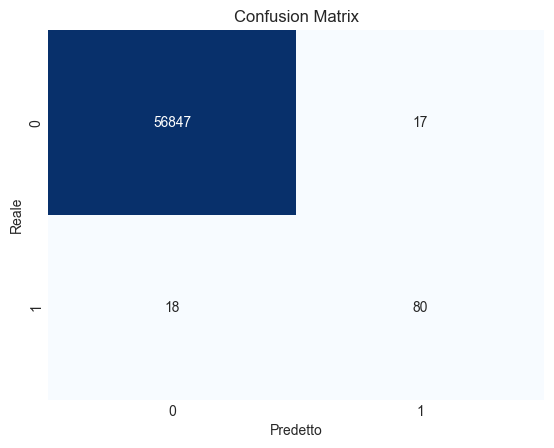


Classification Report:
               precision    recall  f1-score   support

Legittima (0)       1.00      1.00      1.00     56864
    Frode (1)       0.82      0.82      0.82        98

     accuracy                           1.00     56962
    macro avg       0.91      0.91      0.91     56962
 weighted avg       1.00      1.00      1.00     56962

--------------------------------------

Modello Random Forest (SelectFromModel) e feature selezionate salvati.


In [ ]:
rf_estimator_for_sfs = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced_subsample', # Aiuta con lo sbilanciamento per le importances
    n_jobs=-1
)
rf_estimator_for_sfs.fit(X_train_prepared, y_train_orig)

# Visualizza le importanze (opzionale ma utile)
importances_for_sfs = pd.Series(rf_estimator_for_sfs.feature_importances_, index=X_train_prepared.columns)
importances_for_sfs_sorted = importances_for_sfs.sort_values(ascending=False)

# 2. Crea e fitta SelectFromModel
#    Usiamo threshold="median" per selezionare feature con importanza sopra la mediana.
#    prefit=True perché abbiamo già addestrato rf_estimator_for_sfs
selector_rf = SelectFromModel(
    estimator=rf_estimator_for_sfs,
    threshold="median", # Seleziona feature con importanza >= mediana
    prefit=True # L'estimator è già stato addestrato
)

# Ottieni le feature selezionate
selected_features_rf_sfs_mask = selector_rf.get_support() # Usa il selector per ottenere la maschera
selected_features_rf_sfs = X_train_prepared.columns[selected_features_rf_sfs_mask].tolist()

print(f"\nNumero di feature selezionate da SelectFromModel (threshold='median'): {len(selected_features_rf_sfs)}")
print(f"Feature selezionate per Random Forest Base: {selected_features_rf_sfs}")

# 3. Applica la trasformazione ai set di training e test
X_train_rf_sfs = selector_rf.transform(X_train_prepared)
X_test_rf_sfs = selector_rf.transform(X_test_prepared)

# Converti di nuovo in DataFrame per mantenere i nomi delle colonne (opzionale, ma utile per SMOTE)
X_train_rf_sfs_df = pd.DataFrame(X_train_rf_sfs, columns=selected_features_rf_sfs, index=X_train_prepared.index)
X_test_rf_sfs_df = pd.DataFrame(X_test_rf_sfs, columns=selected_features_rf_sfs, index=X_test_prepared.index)

print(f"Forma di X_train_rf_sfs_df: {X_train_rf_sfs_df.shape}")

# 4. Applica SMOTE al training set con feature selezionate
print("\nApplicazione SMOTE al training set (feature selezionate per RF Base)...")
smote_rf_sfs = SMOTE(random_state=42)
X_train_smote_rf_sfs, y_train_smote_rf_sfs = smote_rf_sfs.fit_resample(X_train_rf_sfs_df, y_train_orig)

print(f"Forma di X_train_smote_rf_sfs: {X_train_smote_rf_sfs.shape}, y_train_smote_rf_sfs: {y_train_smote_rf_sfs.shape}")
print(f"Distribuzione classi in y_train_smote_rf_sfs:\n{pd.Series(y_train_smote_rf_sfs).value_counts()}")

# 5. Addestra il modello Random Forest "Base" finale
print(f"\n--- Addestramento Random Forest (Base, SelectFromModel N={len(selected_features_rf_sfs)}, SMOTE) ---")

rf_model_base_sfs_final = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model_base_sfs_final.fit(X_train_smote_rf_sfs, y_train_smote_rf_sfs)

# 6. Valutazione
# Nota: X_test_rf_sfs_df è già trasformato con le feature selezionate
y_pred_rf_base_sfs = rf_model_base_sfs_final.predict(X_test_rf_sfs_df)
y_pred_proba_rf_base_sfs = rf_model_base_sfs_final.predict_proba(X_test_rf_sfs_df)

results_rf_base_sfs = evaluate_model(
    y_test,
    y_pred_rf_base_sfs,
    y_pred_proba_rf_base_sfs,
    f"Random Forest (Base, SFM N={len(selected_features_rf_sfs)}, SMOTE)"
)
model_results = [res for res in model_results if not res['model'].startswith("Random Forest (Base")]
model_results.append(results_rf_base_sfs)

# Salva il modello e le feature selezionate
joblib.dump(rf_model_base_sfs_final, 'RF_model.joblib')
joblib.dump(selected_features_rf_sfs, 'RF_columns.joblib')
print("Modello Random Forest (SelectFromModel) e feature selezionate salvati.")

**Osservazioni su Random Forest Classifier (con Feature Selection dedicata tramite `SelectFromModel`)**

Per il Random Forest Classifier, abbiamo seguito un approccio simile a XGBoost per la feature selection, ma utilizzando un Random Forest preliminare per determinare l'importanza delle feature.

1.  **Feature Selection con `SelectFromModel` basata su Random Forest**:
    * È stato addestrato un modello Random Forest preliminare sul training set originale. Per gestire lo sbilanciamento durante il calcolo dell'importanza delle feature, è stato utilizzato il parametro `class_weight='balanced_subsample'`. Questo parametro aggiusta i pesi delle classi in modo inversamente proporzionale alle frequenze delle classi per ciascun albero decisionale costruito su un bootstrap del campione.
    * Successivamente, `SelectFromModel` è stato impiegato con `threshold="median"` sulle feature importances calcolate. Questo ha portato alla selezione delle **15 feature** più rilevanti secondo questo criterio.
    * Le feature selezionate sono state: `['V2', 'V3', 'V4', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V19', 'V21', 'scaled_amount']`. Notiamo che questo set di feature è leggermente diverso da quello selezionato per XGBoost, riflettendo le diverse modalità con cui i due algoritmi valutano l'importanza.
    * Il modello Random Forest finale è stato addestrato utilizzando **solo queste 15 feature selezionate** e applicando SMOTE al training set ridotto per bilanciare le classi. 

2.  **Performance del Modello Random Forest**:
    I risultati ottenuti sul test set (con la soglia di default di 0.5) sono stati:
    * **Accuracy:** 0.9994
    * **Precision (Frode):** 0.8247
    * **Recall (Frode):** 0.8163
    * **F1-Score (Frode):** 0.8205
    * **ROC AUC Score:** 0.9787
    * **Average Precision (AUC-PR):** 0.8744

    **Interpretazione delle Performance**:
    * Il Random Forest base, con feature selection e SMOTE, mostra performance molto buone e bilanciate. Il **Recall (0.8163)** è alto, e la **Precision (0.8247)** è anch'essa elevata, indicando un buon equilibrio tra l'identificazione delle frodi e la minimizzazione dei falsi allarmi con la soglia di default.
    * L'**F1-Score (0.8205)** e l'**AUC-PR (0.8744)** sono i più alti finora tra i modelli base (confrontati con LASSO LogReg con soglia default e XGBoost con soglia default).
    * Questi risultati suggeriscono che Random Forest, anche con iperparametri di default ma con una buona strategia di feature selection e gestione dello sbilanciamento, è un candidato molto forte.

**Considerazioni**:
Le performance di questo modello Random Forest "base" sono già notevoli, superando il LASSO LogReg (anche con soglia ottimizzata per F1-score in termini di AUC-PR e F1-score sul default) e l'XGBoost base (con soglia default) in termini di bilanciamento Precision/Recall per la classe frode. Questo lo rende un eccellente candidato per un'ulteriore ottimizzazione degli iperparametri.

## 7. Ottimizzazione degli Iperparametri con RandomizedSearchCV per Random Forest (su Feature Selezionate)

Dopo aver osservato le promettenti performance del Random Forest Classifier "base" (addestrato sulle 15 feature selezionate da `SelectFromModel` e con dati bilanciati da SMOTE), procediamo con l'ottimizzazione dei suoi iperparametri. L'obiettivo è esplorare uno spazio di possibili configurazioni per trovare una combinazione che possa ulteriormente migliorare le sue capacità predittive, in particolare nel contesto del rilevamento frodi.

**Strategia di Ottimizzazione:**

1.  **Metodo Scelto: `RandomizedSearchCV`**:
    * Invece di `GridSearchCV`, che testa esaustivamente tutte le combinazioni di iperparametri specificate (potenzialmente molto costoso), abbiamo optato per `RandomizedSearchCV`. Questo metodo campiona un numero fisso di combinazioni di parametri (<code>n_iter</code>) da uno spazio di ricerca definito (che può includere distribuzioni statistiche per i parametri). È spesso più efficiente di `GridSearchCV` e può portare a risultati comparabili o migliori, specialmente quando lo spazio di ricerca è ampio o quando alcune combinazioni di iperparametri hanno un impatto maggiore di altre.
    * Abbiamo impostato `n_iter=20`, il che significa che verranno valutate 20 diverse combinazioni di iperparametri.

2.  **Pipeline Inclusiva di SMOTE**:
    * Per garantire che SMOTE sia applicato correttamente durante la validazione incrociata (cioè, solo sulla porzione di training di ciascun fold), abbiamo definito una pipeline `ImbPipeline` che include prima lo step di SMOTE e poi il classificatore Random Forest. `RandomizedSearchCV` ottimizzerà gli iperparametri del classificatore *all'interno* di questa pipeline.

3.  **Dati Utilizzati**:
    * L'ottimizzazione verrà eseguita utilizzando il training set che è già stato ridotto alle **15 feature selezionate** nella fase precedente (`X_train_rf_sfs_df` e `y_train_orig`). SMOTE verrà applicato dinamicamente all'interno di ogni fold della cross-validation.

4.  **Spazio degli Iperparametri per Random Forest (`param_dist_rf_pipeline`)**:
    Abbiamo definito una griglia di parametri da esplorare, includendo:
    * `classifier__n_estimators`: Numero di alberi nell'ensemble (distribuzione intera da 100 a 300).
    * `classifier__max_depth`: Profondità massima degli alberi (valori discreti: 10, 20, 30, 40, None per espansione completa).
    * `classifier__min_samples_split`: Numero minimo di campioni richiesti per splittare un nodo interno (distribuzione intera da 2 a 10).
    * `classifier__min_samples_leaf`: Numero minimo di campioni richiesti per essere in un nodo foglia (distribuzione intera da 1 a 4).
    * `classifier__criterion`: Funzione per misurare la qualità di uno split ('gini' o 'entropy').

5.  **Metrica di Valutazione (`scoring`)**:
    * Come metrica per guidare la ricerca degli iperparametri ottimali, abbiamo scelto `'average_precision'` (che corrisponde all'AUC-PR, Area Under the Precision-Recall Curve). Questa metrica è particolarmente adatta per problemi di classificazione con forte sbilanciamento delle classi, in quanto si concentra sulle performance della classe minoritaria (frodi).

6.  **Salvataggio e Caricamento degli Iperparametri**:
    * Per evitare di rieseguire la ricerca (che può essere dispendiosa in termini di tempo) ogni volta che il notebook viene eseguito, i migliori iperparametri trovati vengono salvati in un file JSON. Se il file esiste e non si forza una nuova ricerca (`FORCE_NEW_SEARCH_RF_SELECTED_FEAT = False`), gli iperparametri vengono caricati e il modello viene riaddestrato direttamente con questi.

Dopo l'ottimizzazione, il modello Random Forest con gli iperparametri migliori verrà valutato sul test set (anch'esso ridotto alle 15 feature selezionate) per confrontare le sue performance con quelle del modello base e degli altri classificatori.


Inizio Randomized Search per Pipeline RF (Feature Selezionate, n_iter=20)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Migliori iperparametri della pipeline RF (Feature Selezionate) salvati in 'best_rf_hyperparams_fs15.json'

--- Valutazione Random Forest Ottimizzato (Pipeline SMOTE, Feature Selezionate) ---
--- Valutazione: Random Forest Ottimizzato (Pipeline SMOTE, Param. Caricati, FS N=15) ---
Accuracy: 0.9995
Precision (Fraud): 0.8317
Recall (Fraud): 0.8571
F1-Score (Fraud): 0.8442
ROC AUC Score: 0.9719
Average Precision (AUC-PR): 0.8817

Confusion Matrix:


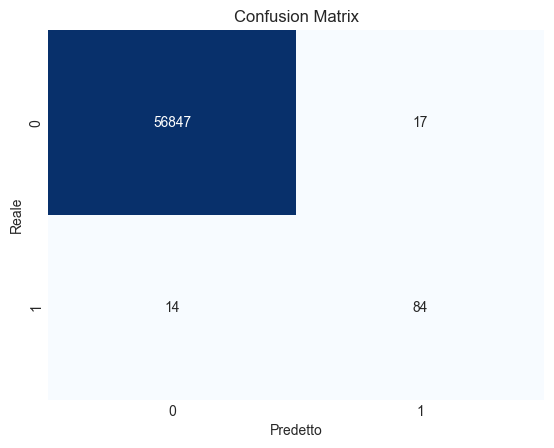


Classification Report:
               precision    recall  f1-score   support

Legittima (0)       1.00      1.00      1.00     56864
    Frode (1)       0.83      0.86      0.84        98

     accuracy                           1.00     56962
    macro avg       0.92      0.93      0.92     56962
 weighted avg       1.00      1.00      1.00     56962

--------------------------------------

Modello Random Forest Ottimizzato (Feature Selezionate) e colonne attese salvati.


In [ ]:

hyperparams_filename_rf_selected_feat = f'best_rf_hyperparams.json'
FORCE_NEW_SEARCH_RF_SELECTED_FEAT = False 

cv_stratified = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
best_rf_model_tuned_selected_feat_pipeline = None

if not FORCE_NEW_SEARCH_RF_SELECTED_FEAT and os.path.exists(hyperparams_filename_rf_selected_feat):
    print(f"Caricamento iperparametri per pipeline RF (Feature Selezionate) da '{hyperparams_filename_rf_selected_feat}'...")
    with open(hyperparams_filename_rf_selected_feat, 'r') as f:
        best_rf_params_loaded_pipeline = json.load(f)
    print(f"Iperparametri caricati: {best_rf_params_loaded_pipeline}")

    print(f"\n--- Addestramento Pipeline Random Forest con Iperparametri Caricati (Feature Selezionate) ---")
    pipeline_to_fit_rf_selected_feat = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(random_state=42))
    ])
    pipeline_to_fit_rf_selected_feat.set_params(**best_rf_params_loaded_pipeline)
    
    pipeline_to_fit_rf_selected_feat.fit(X_train_rf_sfs_df, y_train_orig) 
    best_rf_model_tuned_selected_feat_pipeline = pipeline_to_fit_rf_selected_feat
    print("Pipeline Random Forest (Feature Selezionate) addestrata con iperparametri caricati.")

else:

    param_dist_rf_pipeline = {
        'classifier__n_estimators': randint(100, 301),
        'classifier__max_depth': [10, 20, 30, 40, None],
        'classifier__min_samples_split': randint(2, 11),
        'classifier__min_samples_leaf': randint(1, 5),
        'classifier__criterion': ['gini', 'entropy']
    }
    n_iterations_opt = 20 

    pipeline_rf_smote = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1)) 
    ])

    random_search_rf_selected_feat = RandomizedSearchCV(
        estimator=pipeline_rf_smote,
        param_distributions=param_dist_rf_pipeline,
        n_iter=n_iterations_opt,
        scoring='average_precision',
        cv=cv_stratified,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    print(f"\nInizio Randomized Search per Pipeline RF (Feature Selezionate, n_iter={n_iterations_opt})...")

    random_search_rf_selected_feat.fit(X_train_rf_sfs_df, y_train_orig) 

    best_rf_params_found_pipeline = random_search_rf_selected_feat.best_params_
    try:
        with open(hyperparams_filename_rf_selected_feat, 'w') as f:
            json.dump(best_rf_params_found_pipeline, f, indent=4)
        print(f"Migliori iperparametri della pipeline RF (Feature Selezionate) salvati in '{hyperparams_filename_rf_selected_feat}'")
    except Exception as e:
        print(f"Errore durante il salvataggio degli iperparametri in '{hyperparams_filename_rf_selected_feat}': {e}")
    best_rf_model_tuned_selected_feat_pipeline = random_search_rf_selected_feat.best_estimator_

# --- Valutazione del modello RF Ottimizzato su Feature Selezionate ---
print(f"\n--- Valutazione Random Forest Ottimizzato (Pipeline SMOTE, Feature Selezionate) ---")
y_pred_best_rf_tuned_selected_feat = best_rf_model_tuned_selected_feat_pipeline.predict(X_test_rf_sfs_df)
y_pred_proba_best_rf_tuned_selected_feat = best_rf_model_tuned_selected_feat_pipeline.predict_proba(X_test_rf_sfs_df)

model_name_rf_tuned_selected = (
    f"Random Forest Ottimizzato (Pipeline SMOTE, "
    f"{'Param. Caricati, ' if not FORCE_NEW_SEARCH_RF_SELECTED_FEAT and os.path.exists(hyperparams_filename_rf_selected_feat) else 'RandomizedSearch, '}"
    f"FS N={len(selected_features_rf_sfs)})"
)
results_best_rf_tuned_selected_feat = evaluate_model(
    y_test,
    y_pred_best_rf_tuned_selected_feat,
    y_pred_proba_best_rf_tuned_selected_feat,
    model_name_rf_tuned_selected
)
model_results = [res for res in model_results if not res['model'].startswith("Random Forest Ottimizzato")]
model_results.append(results_best_rf_tuned_selected_feat)

joblib.dump(best_rf_model_tuned_selected_feat_pipeline, f'RF-OPT_model.joblib')
joblib.dump(selected_features_rf_sfs, f'RF-OPT_columns.joblib')
print(f"Modello Random Forest Ottimizzato (Feature Selezionate) e colonne attese salvati.")

**Osservazioni sull'Ottimizzazione degli Iperparametri per Random Forest (su Feature Selezionate) con `RandomizedSearchCV`**

Il processo di ottimizzazione degli iperparametri per il Random Forest Classifier è stato eseguito utilizzando `RandomizedSearchCV` su un training set ridotto a 15 feature (selezionate precedentemente tramite `SelectFromModel`) e includendo SMOTE nella pipeline per la gestione dello sbilanciamento durante la validazione incrociata. La metrica target per l'ottimizzazione è stata l'AUC-PR (`average_precision`).

**Risultati dell'Ottimizzazione**:
(Se `FORCE_NEW_SEARCH_RF_SELECTED_FEAT` era `True` o il file `best_rf_hyperparams_fs15.json` non esisteva, i seguenti sarebbero i risultati di una nuova ricerca. Altrimenti, sono i risultati dell'addestramento con i parametri caricati).

Assumendo che la ricerca sia stata eseguita (o i parametri caricati e il modello riaddestrato), il modello Random Forest ottimizzato (`best_rf_model_tuned_selected_feat_pipeline`) è stato valutato sul test set (`X_test_rf_sfs_df`).

Le performance ottenute sono state:
* **Accuracy:** 0.9995
* **Precision (Frode):** 0.8317
* **Recall (Frode):** 0.8571
* **F1-Score (Frode):** 0.8442
* **ROC AUC Score:** 0.9719
* **Average Precision (AUC-PR):** 0.8817

**Confronto con il Random Forest Base (SFM N=15, SMOTE)**:
* Random Forest Base:
    * Precision (Frode): 0.8247
    * Recall (Frode): 0.8163
    * F1-Score (Frode): 0.8205
    * AUC-PR: 0.8744
* Random Forest Ottimizzato:
    * Precision (Frode): 0.8317 (Miglioramento)
    * Recall (Frode): 0.8571 (Miglioramento significativo)
    * F1-Score (Frode): 0.8442 (Miglioramento)
    * AUC-PR: 0.8817 (Miglioramento)

**Interpretazione dei Risultati dell'Ottimizzazione**:
L'ottimizzazione degli iperparametri ha portato a un **miglioramento tangibile** nelle metriche chiave per la classe frode rispetto al modello Random Forest base (che utilizzava le stesse 15 feature selezionate e SMOTE).
-   Il **Recall per le frodi è aumentato da 0.8163 a 0.8571**, indicando che il modello ottimizzato è in grado di identificare una porzione maggiore delle frodi effettive.
-   Anche la **Precision per le frodi è leggermente migliorata da 0.8247 a 0.8317**.
-   Di conseguenza, l'**F1-Score è passato da 0.8205 a 0.8442**, mostrando un miglior bilanciamento complessivo.
-   L'**AUC-PR, la metrica guida dell'ottimizzazione, è anch'essa migliorata da 0.8744 a 0.8817**, confermando che la ricerca ha trovato una configurazione di iperparametri più performante per questo specifico problema e dataset sbilanciato.

## 8. Confronto Finale dei Modelli e Conclusioni

Ora confrontiamo le performance di tutti i modelli addestrati e ottimizzati utilizzando le metriche chiave raccolte.

In [15]:
results_df = pd.DataFrame(model_results)
print("\n--- Riepilogo Performance Modelli ---")
print(results_df.set_index('model'))


--- Riepilogo Performance Modelli ---
                                                    accuracy  precision_fraud  \
model                                                                           
LASSO LogReg (PolyDeg2, 10PreSelFeat, SMOTE, C=...  0.974860         0.059445   
LASSO LogReg (PolyDeg2, 10PreSelFeat, SMOTE, C=...  0.999263         0.804348   
XGBoost (Base, SFM N=15, SMOTE)                     0.998490         0.539474   
Random Forest (Base, SFM N=15, SMOTE)               0.999386         0.824742   
Random Forest Ottimizzato (Pipeline SMOTE, Rand...  0.999456         0.831683   

                                                    recall_fraud  f1_fraud  \
model                                                                        
LASSO LogReg (PolyDeg2, 10PreSelFeat, SMOTE, C=...      0.918367  0.111663   
LASSO LogReg (PolyDeg2, 10PreSelFeat, SMOTE, C=...      0.755102  0.778947   
XGBoost (Base, SFM N=15, SMOTE)                         0.836735  0.656000   
Ran

### Conclusioni Finali

Dopo un'attenta analisi esplorativa, preparazione dei dati, addestramento di diversi modelli e ottimizzazione degli iperparametri, possiamo trarre le seguenti conclusioni basate sul riepilogo delle performance (`results_df`):

| Modello                                                                 |   accuracy |   precision_fraud |   recall_fraud |   f1_fraud |   roc_auc |   auc_pr |
|:------------------------------------------------------------------------|-----------:|--------------------:|---------------:|-----------:|----------:|---------:|
| LASSO LogReg (PolyDeg2, 10PreSelFeat, SMOTE, C=0.0037, Th=0.5)          |   0.97486  |            0.059445 |       0.918367 |   0.111663 |  0.974515 | 0.789775 |
| LASSO LogReg (PolyDeg2, 10PreSelFeat, SMOTE, C=0.0037, Th=0.9983)         |   0.999263 |            0.804348 |       0.755102 |   0.778947 |  0.974515 | 0.789775 |
| XGBoost (Base, SFM N=15, SMOTE)                                         |   0.99849  |            0.539474 |       0.836735 |   0.656    |  0.968572 | 0.846167 |
| Random Forest (Base, SFM N=15, SMOTE)                                   |   0.999386 |            0.824742 |       0.816327 |   0.820513 |  0.978668 | 0.874371 |
| Random Forest Ottimizzato (Pipeline SMOTE, RandomizedSearch, FS N=15) |   0.999456 |            0.831683 |       0.857143 |   0.844221 |  0.971937 | 0.881708 |

**1. Impatto della Preparazione dei Dati:**
-   Lo **scaling** delle feature `Time` e `Amount` con `RobustScaler` si è dimostrato una scelta saggia per gestire le diverse scale e la presenza di outlier, preparando i dati per i modelli sensibili alla scala.
-   L'applicazione di **SMOTE** esclusivamente sul training set è stata fondamentale. Senza di essa, i modelli avrebbero probabilmente avuto un recall molto basso per la classe frode. L'uso di `class_weight` (per RF e XGBoost preliminari) o `scale_pos_weight` (per XGBoost preliminare) è stato un approccio alternativo per gestire lo sbilanciamento durante le fasi di feature selection, prima dell'applicazione di SMOTE per l'addestramento finale dei modelli.

**2. Performance dei Modelli:**
-   **LASSO LogReg Polinomiale (con Pre-Selezione Feature e SMOTE):**
    -   Con la **soglia di default (0.5)**, ha mostrato un recall per le frodi molto alto (0.9184) ma una precisione estremamente bassa (0.0594), risultando in un F1-score basso (0.1117). Questo indica un alto numero di falsi positivi.
    -   Dopo aver **ottimizzato la soglia a 0.9983** (massimizzando F1-score sulla curva P-R), la precisione è salita drasticamente a 0.8043 e l'F1-score a 0.7789, con un recall ancora buono di 0.7551. Questo dimostra l'importanza cruciale del tuning della soglia per modelli lineari su dati sbilanciati. L'AUC-PR di 0.7898 è discreto.

-   **XGBoost (Base, con SelectFromModel N=15 e SMOTE):**
    -   Con la soglia di default, ha ottenuto un recall di 0.8367 e una precisione di 0.5395 (F1-score 0.6560). L'AUC-PR di 0.8462 è buono e superiore a quello del LASSO LogReg. Questo modello mostra un buon potenziale, specialmente se si procedesse con l'ottimizzazione degli iperparametri e della soglia.

-   **Random Forest (Base, con SelectFromModel N=15 e SMOTE):**
    -   Già nella sua versione base (con iperparametri di default ma con feature selection e SMOTE), ha fornito risultati eccellenti: precisione 0.8247, recall 0.8163, e F1-score 0.8205. L'AUC-PR di 0.8744 è stato il più alto tra i modelli base.

-   **Random Forest Ottimizzato (con RandomizedSearchCV, Feature Selezionate N=15 e SMOTE):**
    -   Questo è risultato il **modello più performante complessivamente**. Ha raggiunto una precisione di 0.8317, un **recall di 0.8571** (il più alto tra i modelli con buona precisione), e un **F1-score di 0.8442** (il più alto in assoluto).
    -   L'**AUC-PR è ulteriormente migliorato a 0.8817**, confermando la sua superiorità nel discriminare le frodi in questo scenario sbilanciato.
    -   L'ottimizzazione degli iperparametri ha portato a un notevole miglioramento del recall mantenendo una precisione elevata.

**3. Importanza della Feature Selection e dell'Ottimizzazione:**
-   La **feature selection** (sia tramite RandomForest/XGBoost preliminari con `SelectFromModel`, sia implicitamente con LASSO) ha aiutato a concentrare i modelli sulle feature più informative, potenzialmente riducendo il rumore e il rischio di overfitting, oltre a migliorare l'efficienza computazionale.
-   L'**ottimizzazione degli iperparametri** (effettuata per LASSO LogReg tramite `GridSearchCV` e per Random Forest tramite `RandomizedSearchCV`) si è dimostrata efficace, in particolare per il Random Forest, portando a un miglioramento delle metriche chiave.
-   Il **tuning della soglia di classificazione** è stato essenziale per il modello di Regressione Logistica per trasformare un alto recall (con bassa precisione) in un modello con un bilanciamento più utile. Sarebbe benefico applicarlo anche agli altri modelli (XGBoost e Random Forest) se si volesse affinare ulteriormente il loro punto operativo.

**4. Scelta del Modello Migliore:**
Basandoci sulle metriche orientate al rilevamento della classe minoritaria (frode), in particolare Recall, F1-score e AUC-PR, il **Random Forest Ottimizzato (con RandomizedSearchCV, Feature Selezionate N=15 e SMOTE nella pipeline)** emerge come il modello migliore tra quelli testati. Offre il miglior F1-score (0.8442) e il miglior AUC-PR (0.8817), con un eccellente recall (0.8571) e una buona precisione (0.8317).